## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

from sklearn.decomposition import PCA
from sklearn import svm

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore") 

## Load MNIST dataset from Github

In [2]:
train = np.loadtxt('https://raw.githubusercontent.com/a4tunado/lectures/master/002/data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('https://raw.githubusercontent.com/a4tunado/lectures/master/002/data/digit/test.csv', delimiter=',', skiprows=1)

In [3]:
# split labels 
train_label = train[:, 0]
# reshape the input data 
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

## Initial dataset vizualization

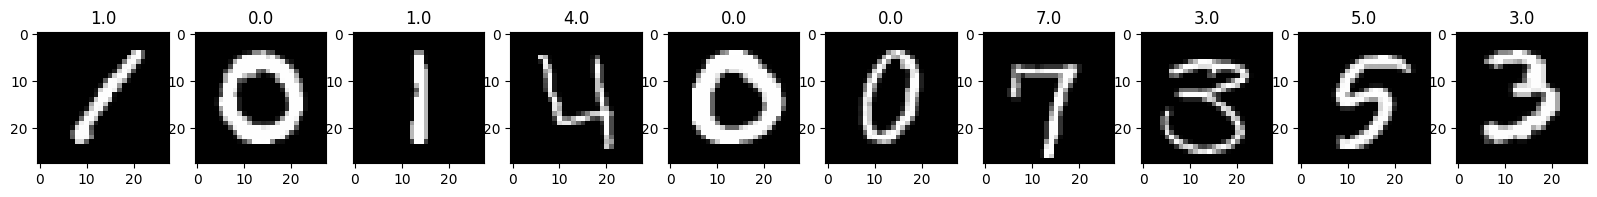

In [4]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:10], 1):
    subplot = fig.add_subplot(1, 10, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Apply Sobel operator to the images

In [6]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)
    
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Calculate the angle and length of the gradient vector

In [7]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y) 

In [8]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

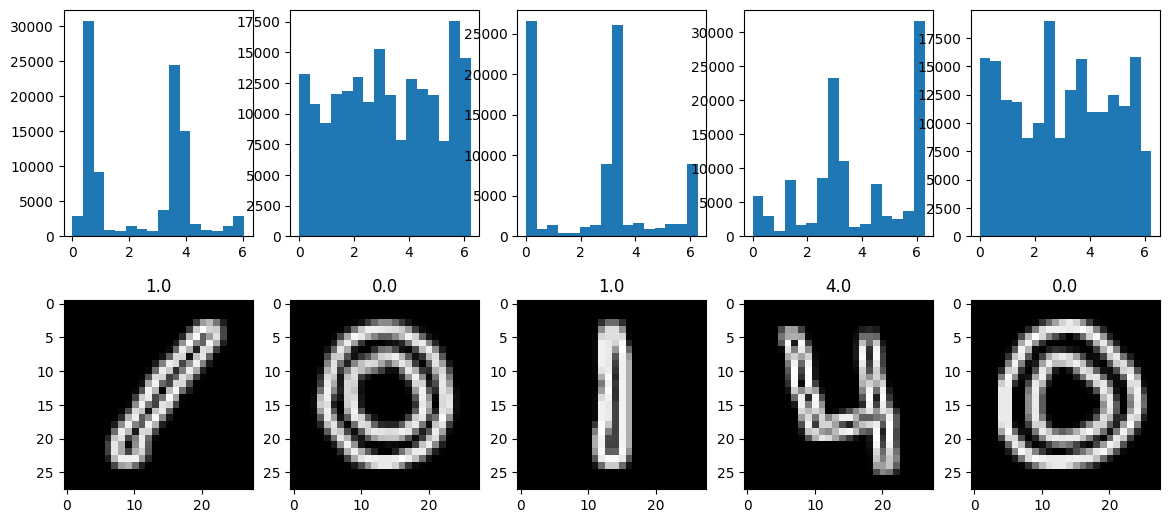

In [40]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Calculate histograms of gradient magnitudes and angles

In [10]:
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [11]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

## Calculate the norm of a vector

In [12]:
# By default L2 norm
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [13]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Define parameters for HOG descriptor

In [19]:
winSize = (28,28)
blockSize = (14,14)
blockStride = (14,14)
cellSize = (7,7)
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
nlevels = 64

hog = cv2.HOGDescriptor(winSize,
                        blockSize,
                        blockStride,
                        cellSize,
                        nbins,
                        derivAperture,
                        winSigma,
                        histogramNormType,
                        L2HysThreshold,
                        gammaCorrection,
                        nlevels)

## Calculate descriptor for 1 image

In [20]:
descriptor = hog.compute(np.uint8(train_img[0]))
print('Descriptor size: %d' % len(descriptor))

Descriptor size: 144


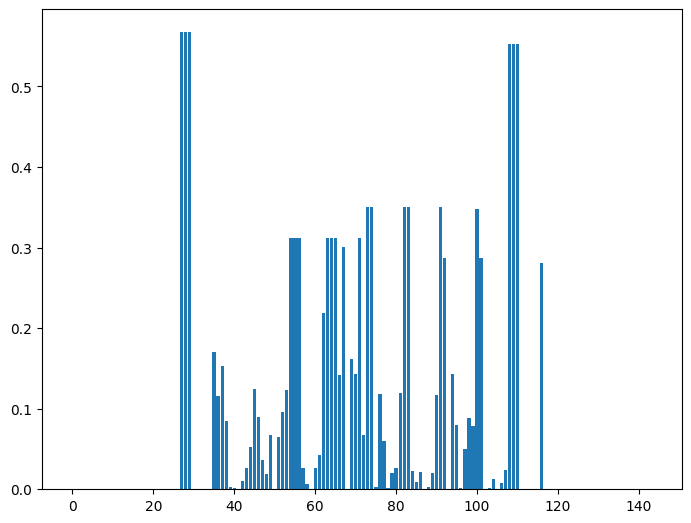

In [41]:
from matplotlib import pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(range(len(descriptor)), descriptor.reshape(-1))
plt.show()

## Calculate descriptor for all images

In [21]:
train_descriptor = np.zeros((len(train_img), 144))
for i in range(len(train_img)):
    train_descriptor[i] = hog.compute(np.uint8(train_img[i])).reshape(-1)
    
test_descriptor = np.zeros((len(test_img), 144))
for i in range(len(test_img)):
    test_descriptor[i] = hog.compute(np.uint8(test_img[i])).reshape(-1)

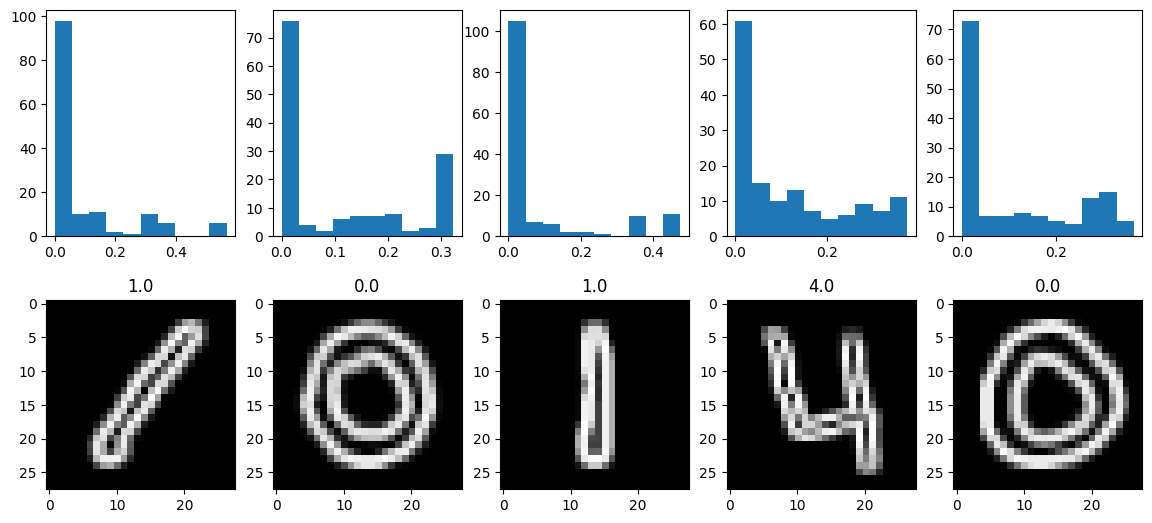

In [45]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_descriptor[i-1].flatten())

## Split into random train and test subsets

In [22]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_descriptor, test_size=0.2,
    random_state=42)

## Train the SVM classifier on the HOG descriptor and Test the classifier on the test set of digits

In [23]:
# Train the SVM classifier on the HOG descriptor
classifier = svm.SVC(kernel='linear', C=1.0)
classifier.fit(x_train, y_train)

# Test the classifier on the test set of digits
y_predict = classifier.predict(x_val)
accuracy = accuracy_score(y_val, y_predict)

mse_rf2 = mean_squared_error(y_val, y_predict)
sqrt_mse_rf2 = np.sqrt(mse_rf2)

print("MSE: ", mse_rf2)
print("SQ MSE: ", sqrt_mse_rf2)
print("Accuracy:", accuracy)



MSE:  0.45345238095238094
SQ MSE:  0.673388729451556
Accuracy: 0.974047619047619


## Оцениваем качество решение на валидационной выборке

In [36]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_predict))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       816
         1.0       0.98      0.99      0.99       909
         2.0       0.98      0.97      0.97       846
         3.0       0.98      0.97      0.97       937
         4.0       0.99      0.97      0.98       839
         5.0       0.99      0.98      0.98       702
         6.0       0.98      0.99      0.98       785
         7.0       0.97      0.96      0.96       893
         8.0       0.94      0.96      0.95       835
         9.0       0.96      0.97      0.96       838

    accuracy                           0.97      8400
   macro avg       0.97      0.97      0.97      8400
weighted avg       0.97      0.97      0.97      8400



In [37]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, y_predict))

[[808   1   3   0   0   0   2   1   1   0]
 [  0 900   2   0   0   0   1   3   3   0]
 [  1   5 820   5   0   1   0   4  10   0]
 [  2   1   4 907   1   4   0   2  14   2]
 [  0   1   1   0 812   0   4   4   4  13]
 [  0   1   0   2   1 689   3   1   4   1]
 [  3   2   0   0   1   2 774   0   3   0]
 [  0   2   6   2   3   0   0 860   2  18]
 [  2   3   4   6   4   3   4   5 801   3]
 [  3   1   1   4   2   0   0  10   6 811]]


## Visualize predictions

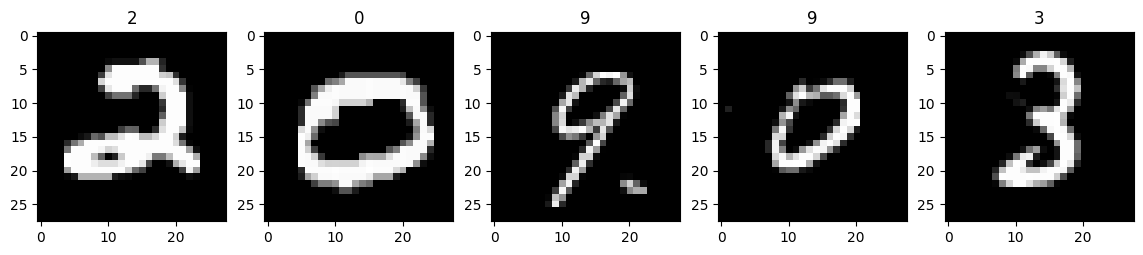

In [46]:
y_predict_test = classifier.predict(test_descriptor)
y_predict_test = y_predict_test.astype(np.uint8)


fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % y_predict_test[i - 1]);
    

## Готовим файл для отправки

In [48]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(y_predict_test, 1):
        dst.write('%s,%s\n' % (i, p))

In [49]:
!head submit.txt

ImageId,Label
1,2
2,0
3,9
4,9
5,3
6,7
7,0
8,3
9,0
